# Anime Text Classification 

In [78]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# Load ML Pkgs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Transformers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# Others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,plot_confusion_matrix

import re 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

# Data Manipulation

In [3]:
anime = pd.read_csv("AnimeQuotes.csv")
df = anime.copy()

In [4]:
df.head()

,Quote,Character,Anime
0,"People’s lives don’t end when they die, it end...",Itachi Uchiha,Naruto
1,"If you don’t take risks, you can’t create a fu...",Monkey D Luffy,One Piece
2,"If you don’t like your destiny, don’t accept it.",Naruto Uzumaki,Naruto
3,"When you give up, that’s when the game ends.",Mitsuyoshi Anzai,Slam Dunk
4,All we can do is live until the day we die. Co...,Deneil Young,Uchuu Kyoudai or Space Brothers


In [5]:
df.shape

(121, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Quote      121 non-null    object
 1   Character  121 non-null    object
 2   Anime      120 non-null    object
dtypes: object(3)
memory usage: 3.0+ KB


In [42]:
characters = df["Character"].unique()

In [43]:
animes = df["Anime"].unique()

# NaN Values

In [45]:
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
0,Quote,0.0
1,Character,0.0
2,Anime,0.0
3,logistic,0.0
4,naivebayes,0.0
5,xgboost,0.0


In [25]:
df.dropna(inplace=True)

In [ ]:
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN.sort_values("percentage", ascending=False)

# Text Preprocessing

In [46]:
!pip install textblob
!pip install nltk 

from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

In [47]:
#lowercase
df["Quote"] = df["Quote"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [48]:
#numerical values
df["Quote"] = df["Quote"].str.replace("\d","")

In [49]:
#punctation
df["Quote"] = df["Quote"].str.replace("[^\w\s]","")

In [50]:
#stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")
df["Quote"] = df["Quote"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
#lemmatization 
from textblob import Word
nltk.download("wordnet")
df["Quote"] = df["Quote"].apply(lambda x: " ".join([Word(x).lemmatize()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
#word tokenization
from nltk.tokenize import word_tokenize
df["tokens"] = df["Quote"].apply(lambda x: TextBlob(x).words)

In [53]:
#frequency
df["frequency"] = df["Quote"].apply(lambda x: len(str(x).split(" "))) 

In [72]:
df.groupby("frequency").max()
df[df["Quote"].str.contains("youll realize")]
longest_comment=df.iloc[90,0]
print(longest_comment)

youll realize truly love someone already caused enormous pain enemies never hurt way loved ones people close heart give piercing wound love doubleedged sword heal wound faster sink blade even deeper


In [73]:
TextBlob(longest_comment).tags

[('youll', 'NN'),
 ('realize', 'VB'),
 ('truly', 'RB'),
 ('love', 'VB'),
 ('someone', 'NN'),
 ('already', 'RB'),
 ('caused', 'VBD'),
 ('enormous', 'JJ'),
 ('pain', 'NN'),
 ('enemies', 'NNS'),
 ('never', 'RB'),
 ('hurt', 'VBP'),
 ('way', 'NN'),
 ('loved', 'VBN'),
 ('ones', 'NNS'),
 ('people', 'NNS'),
 ('close', 'RB'),
 ('heart', 'NN'),
 ('give', 'NN'),
 ('piercing', 'NN'),
 ('wound', 'NN'),
 ('love', 'VBD'),
 ('doubleedged', 'VBN'),
 ('sword', 'NN'),
 ('heal', 'NN'),
 ('wound', 'IN'),
 ('faster', 'JJR'),
 ('sink', 'NN'),
 ('blade', 'VBD'),
 ('even', 'RB'),
 ('deeper', 'JJR')]

In [74]:
df.head()

,Quote,Character,Anime,logistic,naivebayes,xgboost,tokens,frequency
0,peoples lives dont end die ends lose faith,Itachi Uchiha,Naruto,Haikyuu,Haikyuu,One Piece,"[peoples, lives, dont, end, die, ends, lose, f...",8
1,dont take risks cant create future,Monkey D Luffy,One Piece,One Piece,One Piece,One Piece,"[dont, take, risks, cant, create, future]",6
2,dont like destiny dont accept,Naruto Uzumaki,Naruto,Naruto,Naruto,Naruto,"[dont, like, destiny, dont, accept]",5
3,give thats game ends,Mitsuyoshi Anzai,Slam Dunk,Haikyuu,Haikyuu,Slam Dunk,"[give, thats, game, ends]",4
4,live day die control canand fly free,Deneil Young,Uchuu Kyoudai or Space Brothers,Attack on Titan,Attack on Titan,Fairy Tail,"[live, day, die, control, canand, fly, free]",7


# Data Visualization 

In [75]:
!pip install wordcloud

from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [76]:
# we need convert all reviews to single text 

text = " ".join(i for i in df.Quote)

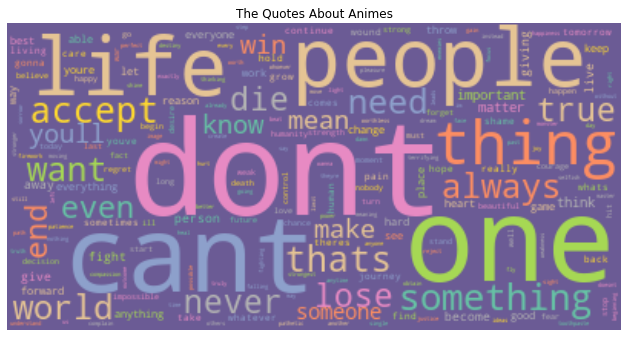

In [79]:
wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set2",
    collocations=False).generate(text)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Quotes About Animes")
plt.show()

In [89]:
print("\n",
      "\n",text.count("thing"),
      "\n",text.count("one"),
      "\n",text.count("dont"),
      "\n",text.count("life"),
      "\n",text.count("people"),
      "\n",text.count("something"),
      "\n",text.count("accept"),
      "\n",text.count("lose"),
      "\n",text.count("world"),
     )


 
 36 
 34 
 22 
 13 
 13 
 11 
 10 
 10 
 9


In [90]:
data = {
    "title": ["thing", "one" ,"dont", "life", "people", "something", 
              "accept","lose","world"],
    "count": [36, 34 ,22, 13, 13, 11, 10, 10, 9],
}

In [91]:
data = pd.DataFrame(data)
data.head(10)

,title,count
0,thing,36
1,one,34
2,dont,22
3,life,13
4,people,13
5,something,11
6,accept,10
7,lose,10
8,world,9


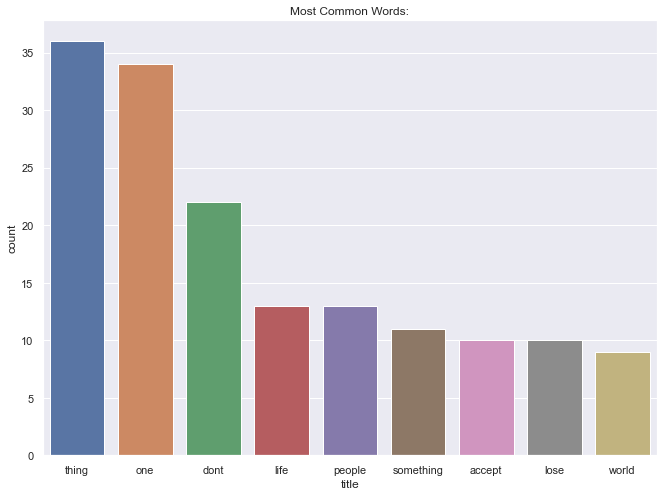

In [95]:
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.9})
sns.set(rc = {'figure.figsize':(11,8)})
sns.barplot(data=data, x="title", y="count").set(title="Most Common Words:");

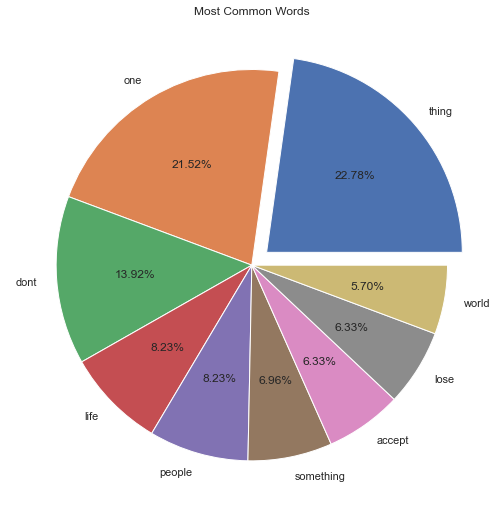

In [203]:
fig = plt.figure(figsize =(12, 9))
myexplode = [0.1, 0, 0, 0,0,0,0,0,0] 
plt.pie(data["count"], labels = data["title"], autopct='%1.2f%%', explode=myexplode)
plt.title("Most Common Words")

plt.show()

# Machine Learning

In [205]:
#train test split
from sklearn.model_selection import train_test_split
X = df.Quote
y = df.Anime
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [206]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((84,), (36,), (84,), (36,))

# Applying Logistic Regression

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

lr.fit(X_train,y_train)
y_pred1 = lr.predict(X_test)

print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")

Accuracy is : 0.1388888888888889


# Aplyying Naive Bayes

In [208]:
from sklearn.naive_bayes import MultinomialNB


naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)

y_pred = naivebayes.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')

accuracy 0.1388888888888889


# Applying XGboost

In [209]:
from xgboost import XGBClassifier

xgboost = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)

print(f'accuracy {accuracy_score(y_pred,y_test)}')

D:\spyde\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy 0.1111111111111111


In [210]:
df["logistic"] = lr.predict(df["Quote"])
df["naivebayes"] = naivebayes.predict(df["Quote"])
df["xgboost"] = xgboost.predict(df["Quote"])

In [232]:
df.head(50)

,Quote,Character,Anime,logistic,naivebayes,xgboost,tokens,frequency
0,peoples lives dont end die ends lose faith,Itachi Uchiha,Naruto,One Piece,One Piece,Naruto,"[peoples, lives, dont, end, die, ends, lose, f...",8
1,dont take risks cant create future,Monkey D Luffy,One Piece,One Piece,One Piece,One Piece,"[dont, take, risks, cant, create, future]",6
2,dont like destiny dont accept,Naruto Uzumaki,Naruto,Naruto,Naruto,Naruto,"[dont, like, destiny, dont, accept]",5
3,give thats game ends,Mitsuyoshi Anzai,Slam Dunk,Haikyuu,Attack on Titan,Haikyuu,"[give, thats, game, ends]",4
4,live day die control canand fly free,Deneil Young,Uchuu Kyoudai or Space Brothers,Haikyuu,Haikyuu,Haikyuu,"[live, day, die, control, canand, fly, free]",7
5,forgetting like wound wound may heal already l...,Monkey D Luffy,One Piece,One Piece,One Piece,One Piece,"[forgetting, like, wound, wound, may, heal, al...",9
6,pathetic give something even give shot,Reiko Mikami,Another,Haikyuu,Haikyuu,Haikyuu,"[pathetic, give, something, even, give, shot]",6
7,dont share someones pain never understand,Nagato,Naruto,Naruto,Naruto,Naruto,"[dont, share, someones, pain, never, understand]",6
8,whatever lose youll find throw away youll neve...,Himura Kenshin,Rurouni Kenshin,Rurouni Kenshin,Attack on Titan,Haikyuu,"[whatever, lose, youll, find, throw, away, you...",10
9,dont know tomorrow holds thats live everything...,Natsu Dragneel,Fairy Tail,Fairy Tail,Fairy Tail,Fairy Tail,"[dont, know, tomorrow, holds, thats, live, eve...",9


In [212]:
accuracy_score(y_pred,lr.predict(df["Quote"])[:36])

0.2222222222222222

In [213]:
accuracy_score(y_pred,naivebayes.predict(df["Quote"])[:36])

0.2222222222222222

In [214]:
accuracy_score(y_pred,xgboost.predict(df["Quote"])[:36])

0.4444444444444444

In [239]:
df2 = pd.DataFrame(df.xgboost, columns=["xgboost"])
df32 = pd.DataFrame(df.Quote, columns=["Quote"])

In [242]:
df_merged = pd.concat([df2, df31], axis=1)
df_merged.head()

,xgboost,Quote
0,Naruto,peoples lives dont end die ends lose faith
1,One Piece,dont take risks cant create future
2,Naruto,dont like destiny dont accept
3,Haikyuu,give thats game ends
4,Haikyuu,live day die control canand fly free


# Sentiment 

In [244]:
!pip install textblob 
from textblob import TextBlob

In [246]:
blob_emptyline2 = []

for i in df_merged["Quote"]:
    blob = TextBlob(i).sentiment
    blob_emptyline2.append(blob)

In [247]:
df_blob2 = pd.DataFrame(blob_emptyline2)

In [249]:
df_blob3 = pd.concat([df_merged.reset_index(drop=True), df_blob2], axis=1)
df_blob3.head()

,xgboost,Quote,polarity,subjectivity
0,Naruto,peoples lives dont end die ends lose faith,0.000000,0.000000
1,One Piece,dont take risks cant create future,0.000000,0.125000
2,Naruto,dont like destiny dont accept,0.000000,0.000000
3,Haikyuu,give thats game ends,-0.400000,0.400000
4,Haikyuu,live day die control canand fly free,0.445455,0.733333


In [250]:
df_blob3["Sentiment"] =  np.where(df_blob3["polarity"] >= 0 , "Positive", "Negative")

In [251]:
df_blob3.head()

,xgboost,Quote,polarity,subjectivity,Sentiment
0,Naruto,peoples lives dont end die ends lose faith,0.000000,0.000000,Positive
1,One Piece,dont take risks cant create future,0.000000,0.125000,Positive
2,Naruto,dont like destiny dont accept,0.000000,0.000000,Positive
3,Haikyuu,give thats game ends,-0.400000,0.400000,Negative
4,Haikyuu,live day die control canand fly free,0.445455,0.733333,Positive


# Result

In [252]:
result = df_blob3["Sentiment"].value_counts()

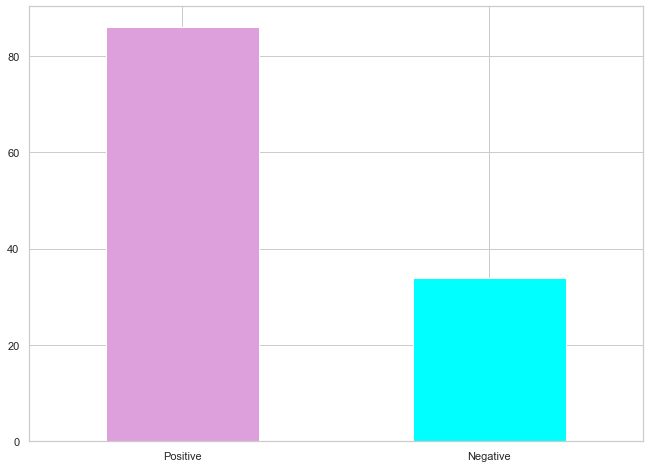

In [254]:
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
result.plot(kind="bar", rot=0, color=["plum","cyan"]);

In [255]:
df_blob3.groupby("Sentiment").count()

,xgboost,Quote,polarity,subjectivity
Sentiment,,,,
Negative,34,34,34,34
Positive,86,86,86,86


In [265]:
df_blob3.groupby("polarity").max()
df[df["Quote"].str.contains("worlds perfect")]
df.iloc[67,0]
TextBlob(df.iloc[67,0]).tags

[('worlds', 'NNS'),
 ('perfect', 'VBP'),
 ('us', 'PRP'),
 ('trying', 'VBG'),
 ('best', 'JJS'),
 ('thats', 'NNS'),
 ('makes', 'VBZ'),
 ('damn', 'RB'),
 ('beautiful', 'JJ')]

In [266]:
df_blob3.groupby("polarity").min()
df[df["Quote"].str.contains("fear evil")]
df.iloc[63,0]
TextBlob(df.iloc[63,0]).tags

[('fear', 'NN'),
 ('evil', 'JJ'),
 ('tells', 'VBZ'),
 ('weakness', 'NN'),
 ('know', 'VB'),
 ('weakness', 'NN'),
 ('become', 'RB'),
 ('stronger', 'JJR'),
 ('well', 'RB'),
 ('kinder', 'VB')]